In [45]:
import pandas as pd
import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
from spellchecker import SpellChecker
from empath import Empath
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# 1) Feature Engineering

In [115]:
df = pd.read_csv('raw_data.csv', index_col=0)
df

,label,text
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,ham,I sent my scores to sophas and i had to do sec...
2,spam,We know someone who you know that fancies you....
3,ham,Only if you promise your getting out as SOON a...
4,spam,Congratulations ur awarded either �500 of CD g...
...,...,...
59236,ham,start date : 12 / 21 / 01 ; hourahead hour : 8...
59237,spam,pocket printer a 6 size for pdas t o d a y ' s...
59238,spam,all - natural - fast - acting - ci : alis remo...
59239,ham,here is next week ' s neon lesson . let me kno...


In [8]:
scraped_df = pd.read_csv('compiled_raw_data.csv')
labels = np.array(['spam'] * len(scraped_df))
scraped_df['label'] = labels
scraped_df = scraped_df[['label','text']]
scraped_df

,label,text
0,spam,@ee00 Verizon LTE 9:05 AM 7) =\n\n< 800392922...
1,spam,+1 (307) 249-2155\n\nTax refund xt Messag\n\nT...
2,spam,+1 (838) 245-8896\n\nText Message\nToday 9:05 ...
3,spam,<e s\n\nText Message\nToday 2:10 PM\n\nYour ca...
4,spam,Sorry for contacting you this way it‚Äôs\ndue ...
...,...,...
119,spam,Google oe\n\nGmail ~ 6 e a- d-\nImportant: You...
120,spam,FedEx.\n\nExpress\nParcel Tracking\n\nDear Cus...
121,spam,"HiAll,\n\nThis is to provide notice of our new..."
122,spam,Don't trust an email\njust because it's\nfrom ...


In [18]:
stop_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.porter.PorterStemmer()

def remove_unknown_ch(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9\s' + re.escape(punctuation) + ']', '', str(text))
    return cleaned_text

def preprocess_text(text):
    text = re.sub(r'[^a-z\s]', '', str(text))
    text = text.lower()
    tokens = text.split()
    stop_list = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_list]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def calculate_punctuation_percentage(text):
    #percentage of punctuations to characters
    total_chars = len(text)
    punctuation_chars = sum([1 for char in text if char in punctuation])
    return (punctuation_chars / total_chars) * 100 if total_chars > 0 else 0

def calculate_num_chars(text):
    return len(text)

def calculate_num_words(text):
    words = word_tokenize(text)
    num_words = 0
    for word in words:
        if word in punctuation:
            pass
        else:
            num_words += 1
    return num_words

def calculate_num_sentences(text):
    sentences = sent_tokenize(text)
    return len(sentences)

def count_misspellings(text):
    words = word_tokenize(text)
    spell = SpellChecker()
    num_mispelled = len(list(spell.unknown(words)))
    return(num_mispelled)

def calculate_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

def determine_polarity(score): 
    return 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')

def extract_emotions(text):
    """
    Each value epresents the degree to which the input text 
    expresses or relates to each predefined category
    0 - No relation
    1 - Strong relation
    """
    lexicon = Empath()
    emotions = lexicon.analyze(str(text), normalize=True)
    return emotions

def check_url_presence(text):
    if re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text) != None:
        return 1
    else:
        return 0

def check_phone_number_presence(text):
    #may need to add more patterns for phone numbers
    if re.search(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', text) != None:
        return 1
    else:
        return 0

# Function to count number of POS verb tags
def count_pos_verbs(text):
    tokens = nltk.pos_tag(word_tokenize(text))
    verb_tags = [tag for word, tag in tokens if tag.startswith('VB')]
    return len(verb_tags)

def calculate_spaces_percentage(text):
    total_chars = len(text)
    num_spaces = text.count(' ')
    return (num_spaces / total_chars) * 100 if total_chars > 0 else 0

def encode(text):
    if text == 'spam':
        return 1
    else:
        return 0
    
def generate_features(df):
    df['cleaned_text'] = df['text'].apply(remove_unknown_ch)
    df['preprocessed_tokens'] = df['text'].apply(preprocess_text)

    df['punctuation_percentage'] = df['cleaned_text'].apply(calculate_punctuation_percentage)
    df['num_chars'] = df['cleaned_text'].apply(calculate_num_chars)
    df['num_sentences'] = df['cleaned_text'].apply(calculate_num_sentences)
    df['num_words'] = df['cleaned_text'].apply(calculate_num_words)
    df['num_misspellings'] = df['cleaned_text'].apply(count_misspellings)
    df['misspelling_percentage'] = df['num_misspellings']/df['num_words'] * 100
    df['num_pos_verbs'] = df['cleaned_text'].apply(count_pos_verbs)
    df['pos_verbs_percentage'] = df['num_pos_verbs']/df['num_words'] * 100
    df['spaces_percentage'] = df['cleaned_text'].apply(calculate_spaces_percentage)

    df['sentiment_score'] = df['cleaned_text'].apply(calculate_sentiment_score)
    df['polarity'] = df['sentiment_score'].apply(determine_polarity)
    df['emotions'] = df['cleaned_text'].apply(extract_emotions)
    for label in emotion_labels:
        col_name = label.lower() + '_score'
        df[col_name] = df['emotions'].apply(lambda x: x[label] if x is not None and label in x else 0)

    df['url_presence'] = df['cleaned_text'].apply(check_url_presence)
    df['phone_number_presence'] = df['cleaned_text'].apply(check_phone_number_presence)
    df['binary_label'] = df['label'].apply(encode)
    return df

emotion_labels = ['deception', 'money','payment','celebration','achievement']

In [176]:
df_features = generate_features(df)
df_features.head()

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label,pos_verbs_percentage
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...","Funny fact Nobody teaches volcanoes 2 erupt, t...","[funni, fact, nobodi, teach, volcano, erupt, t...",1.324503,151,1,26,2,7.692308,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.038461...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,11.538462
1,ham,I sent my scores to sophas and i had to do sec...,I sent my scores to sophas and i had to do sec...,"[sent, score, sopha, secondari, applic, school...",1.809955,221,3,43,2,4.651163,...,"{'help': 0.0, 'office': 0.023255813953488372, ...",0.0,0.046512,0.046512,0.000000,0.0,0,0,0,27.906977
2,spam,We know someone who you know that fancies you....,We know someone who you know that fancies you....,"[know, someon, know, fanci, call, find, pobox,...",2.970297,101,3,19,3,15.789474,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,21.052632
3,ham,Only if you promise your getting out as SOON a...,Only if you promise your getting out as SOON a...,"[promis, get, soon, youll, text, morn, let, kn...",2.419355,124,2,29,2,6.896552,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,20.689655
4,spam,Congratulations ur awarded either �500 of CD g...,Congratulations ur awarded either 500 of CD gi...,"[congratul, ur, award, either, cd, gift, vouch...",2.054795,146,1,22,5,22.727273,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.043478,0.0,0,0,1,9.090909


In [19]:
scraped_df_features = generate_features(scraped_df)
scraped_df_features.head()

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,polarity,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label
0,spam,@ee00 Verizon LTE 9:05 AM 7) =\n\n< 800392922...,@ee00 Verizon LTE 9:05 AM 7) =\n\n< 800392922...,"[ee, erizon, pinnba, etail, ext, essag, oday, ...",7.142857,224,2,35,11,31.428571,...,negative,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,1,1
1,spam,+1 (307) 249-2155\n\nTax refund xt Messag\n\nT...,+1 (307) 249-2155\n\nTax refund xt Messag\n\nT...,"[ax, refund, xt, essag, scam, ongratul, our, e...",6.818182,176,3,28,6,21.428571,...,positive,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.037037,0.111111,0.000000,0.0,0,0,1
2,spam,+1 (838) 245-8896\n\nText Message\nToday 9:05 ...,+1 (838) 245-8896\n\nText Message\nToday 9:05 ...,"[ext, essag, oday, brows, histori, show, visit...",6.521739,184,3,33,4,12.121212,...,positive,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1
3,spam,<e s\n\nText Message\nToday 2:10 PM\n\nYour ca...,<e s\n\nText Message\nToday 2:10 PM\n\nYour ca...,"[e, ext, essag, oday, card, charg, last, rder,...",5.325444,169,2,31,6,19.354839,...,positive,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1
4,spam,Sorry for contacting you this way it‚Äôs\ndue ...,Sorry for contacting you this way its\ndue to ...,"[orri, contact, way, due, urgenc, attach, h, t...",4.491726,423,7,79,4,5.063291,...,positive,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.012658,0.0,0,0,1


In [25]:
combined_df = pd.concat([df_features, scraped_df_features])
combined_df.reset_index(drop=True, inplace=True)
combined_df = combined_df[['label', 'text', 'cleaned_text', 'preprocessed_tokens',
       'punctuation_percentage', 'num_chars', 'num_sentences', 'num_words',
       'num_misspellings', 'misspelling_percentage', 'num_pos_verbs',
       'spaces_percentage', 'sentiment_score', 'polarity', 'emotions',
       'deception_score', 'money_score', 'payment_score', 'celebration_score',
       'achievement_score', 'url_presence', 'phone_number_presence',
       'binary_label', 'pos_verbs_percentage']]
combined_df.head()

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label,pos_verbs_percentage
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...","Funny fact Nobody teaches volcanoes 2 erupt, t...","['funni', 'fact', 'nobodi', 'teach', 'volcano'...",1.324503,151,1,26,2,7.692308,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.038461...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,11.538462
1,ham,I sent my scores to sophas and i had to do sec...,I sent my scores to sophas and i had to do sec...,"['sent', 'score', 'sopha', 'secondari', 'appli...",1.809955,221,3,43,2,4.651163,...,"{'help': 0.0, 'office': 0.023255813953488372, ...",0.0,0.046512,0.046512,0.000000,0.0,0,0,0,27.906977
2,spam,We know someone who you know that fancies you....,We know someone who you know that fancies you....,"['know', 'someon', 'know', 'fanci', 'call', 'f...",2.970297,101,3,19,3,15.789474,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,21.052632
3,ham,Only if you promise your getting out as SOON a...,Only if you promise your getting out as SOON a...,"['promis', 'get', 'soon', 'youll', 'text', 'mo...",2.419355,124,2,29,2,6.896552,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,20.689655
4,spam,Congratulations ur awarded either �500 of CD g...,Congratulations ur awarded either 500 of CD gi...,"['congratul', 'ur', 'award', 'either', 'cd', '...",2.054795,146,1,22,5,22.727273,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.043478,0.0,0,0,1,9.090909


# 2) Data Preprocessing
In this section, we are checking for errors in engineered features and resolving them

In [26]:
nan_counts = combined_df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
label                     0
text                      2
cleaned_text              7
preprocessed_tokens       0
punctuation_percentage    0
num_chars                 0
num_sentences             0
num_words                 0
num_misspellings          0
misspelling_percentage    0
num_pos_verbs             0
spaces_percentage         0
sentiment_score           0
polarity                  0
emotions                  0
deception_score           0
money_score               0
payment_score             0
celebration_score         0
achievement_score         0
url_presence              0
phone_number_presence     0
binary_label              0
pos_verbs_percentage      0
dtype: int64


In [27]:
combined_df.fillna(0, inplace=True)
combined_df.replace([np.inf, -np.inf], 0, inplace=True)
mask = combined_df['num_pos_verbs'] > combined_df['num_words']
combined_df.loc[mask, 'pos_verbs_percentage'] = 100

In [28]:
combined_df.to_csv('final_data_combined.csv')

# 3) Feature Analysis
We want to identify features that are important in helping us to classify whether a text is spam or ham. Hence, we want to find any significant differences between the two categories for each of the features we have engineered.

In [29]:
grouped = combined_df.groupby('binary_label')

In [32]:
grouped.count()['label']/sum(grouped.count()['label']) #find percentage of class 1 and 0

binary_label
0    0.600202
1    0.399798
Name: label, dtype: float64

In [33]:
selected_features = ['punctuation_percentage', 'num_chars', 'num_sentences', 'num_words',
       'misspelling_percentage', 'pos_verbs_percentage',
       'spaces_percentage', 'sentiment_score',
       'deception_score', 'money_score', 'payment_score', 'celebration_score',
       'achievement_score']

grouped[selected_features].mean()

,punctuation_percentage,num_chars,num_sentences,num_words,misspelling_percentage,pos_verbs_percentage,spaces_percentage,sentiment_score,deception_score,money_score,payment_score,celebration_score,achievement_score
binary_label,,,,,,,,,,,,,
0,3.592893,914.205636,9.762622,151.770284,13.615259,17.294459,19.765124,0.416229,0.000423,0.004885,0.003994,0.005094,0.002296
1,3.743880,997.528651,13.043693,160.183618,14.600095,14.449353,20.752161,0.491567,0.000596,0.011247,0.009538,0.004119,0.004319


In [34]:
quantiles = grouped[selected_features].quantile([0.25, 0.5, 0.75])

quantiles

punctuation_percentage  num_chars  num_sentences  \
binary_label                                                          
0            0.25                0.000000      68.00            1.0   
             0.50                2.631579     333.00            2.0   
             0.75                5.633803     799.00            8.0   
1            0.25                1.127856     185.00            1.0   
             0.50                3.053435     451.00            6.0   
             0.75                5.074119     905.75           14.0   

                   num_words  misspelling_percentage  pos_verbs_percentage  \
binary_label                                                                 
0            0.25       14.0                5.434783             13.333333   
             0.50       57.0               10.000000             16.666667   
             0.75      143.0               16.666667             20.833333   
1            0.25       31.0                4.761905             10.667364   
             0.50       74.0               10.198935             14.611006   
             0.75      148.0               19.230769             18.085106   

                   spaces_percentage  sentiment_score  deception_score  \
binary_label                                                             
0            0.25          17.857143           0.0000              0.0   
             0.50          19.678715           0.5267              0.0   
             0.75          21.798478           0.8943              0.0   
1            0.25          17.595921           0.0000              0.0   
             0.50          19.583333           0.7430              0.0   
             0.75          21.853043           0.9381              0.0   

                   money_score  payment_score  celebration_score  \
binary_label                                                       
0            0.25     0.000000       0.000000           0.000000   
             0.50     0.000000       0.000000           0.000000   
             0.75     0.002825       0.000000           0.002186   
1            0.25     0.000000       0.000000           0.000000   
             0.50     0.000000       0.000000           0.000000   
             0.75     0.014834       0.011494           0.001926   

                   achievement_score  
binary_label                          
0            0.25           0.000000  
             0.50           0.000000  
             0.75           0.000000  
1            0.25           0.000000  
             0.50           0.000000  
             0.75           0.003422

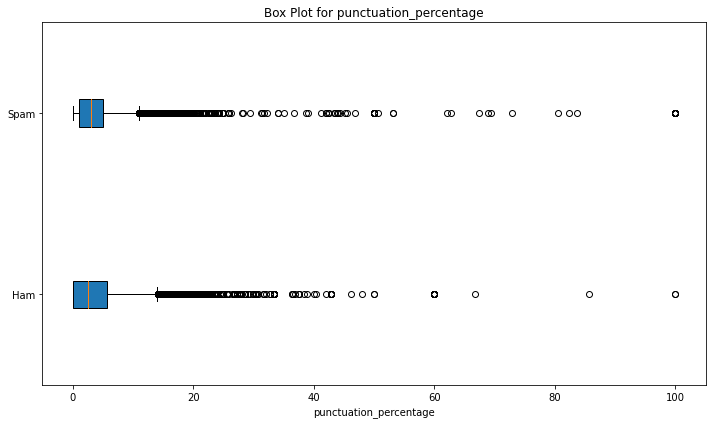

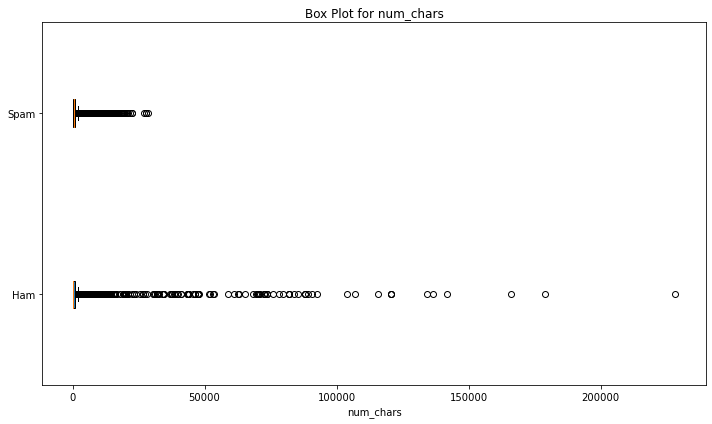

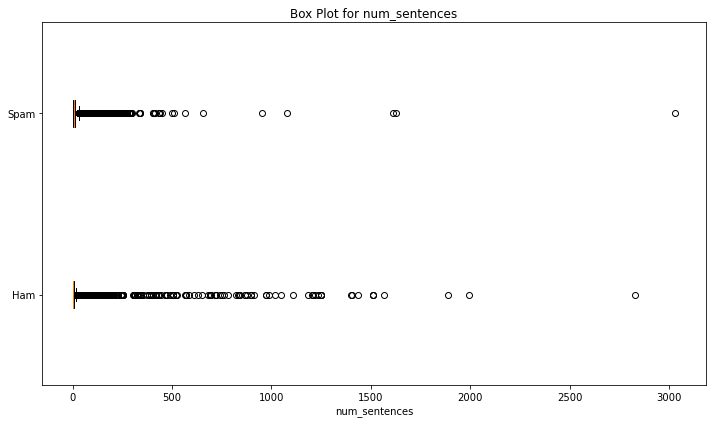

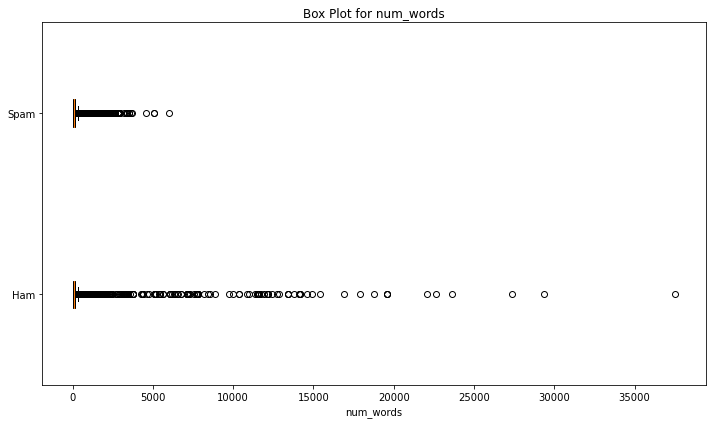

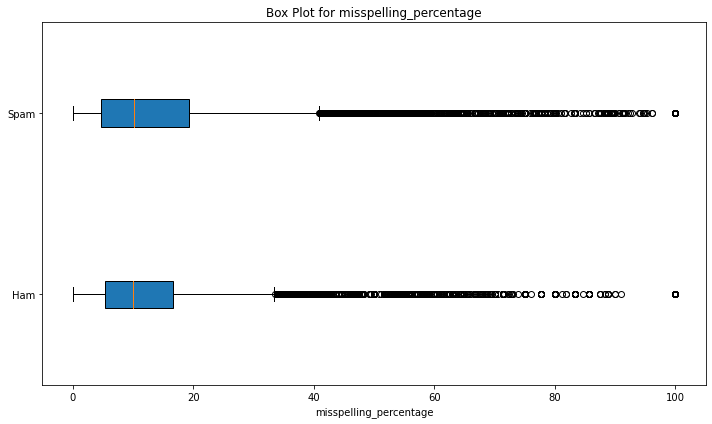

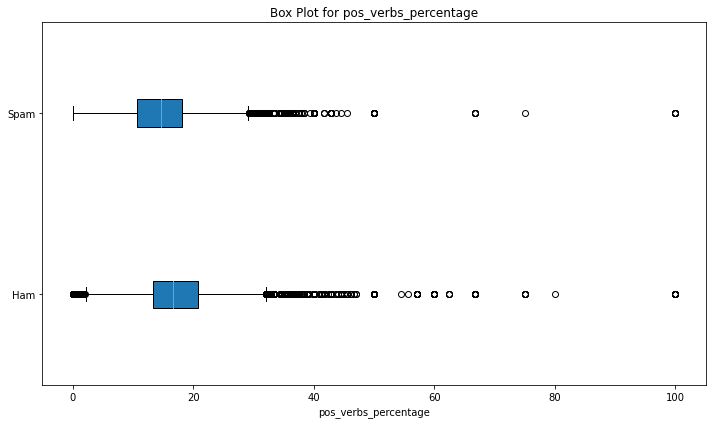

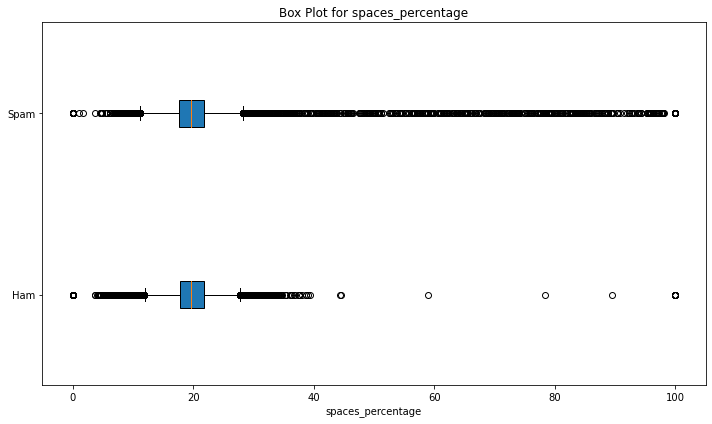

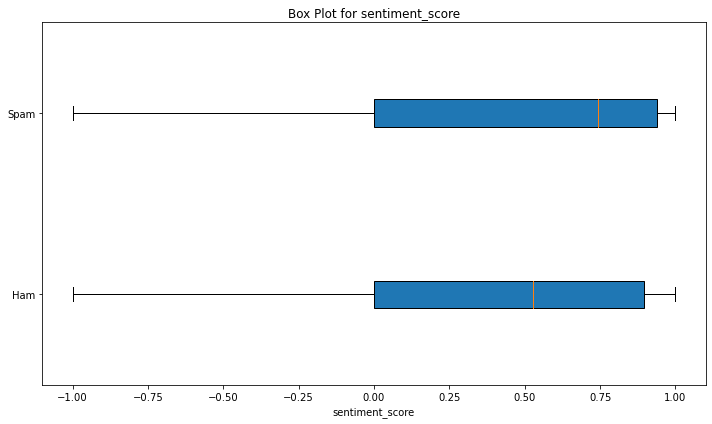

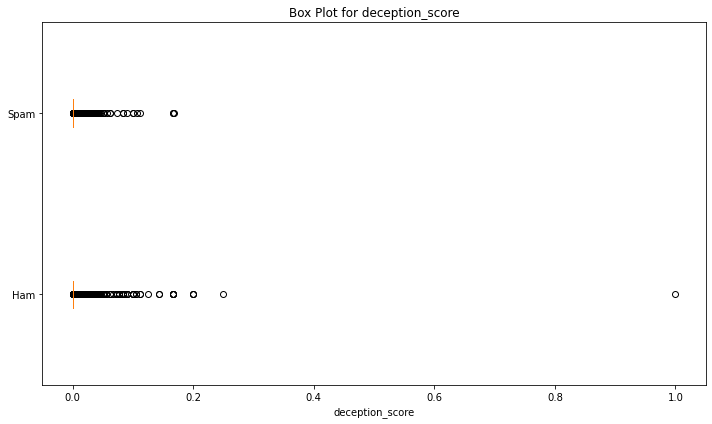

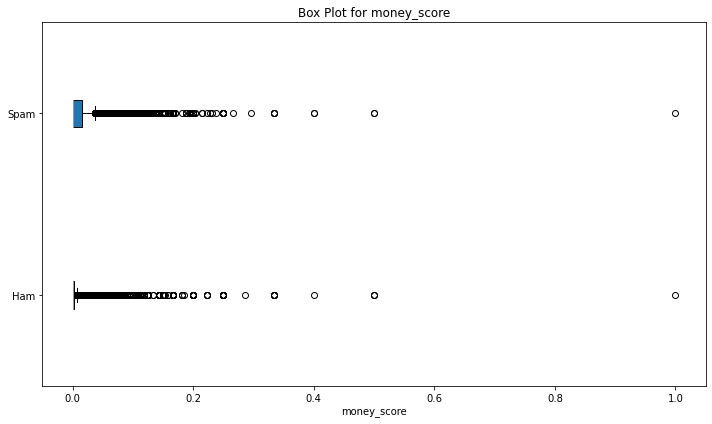

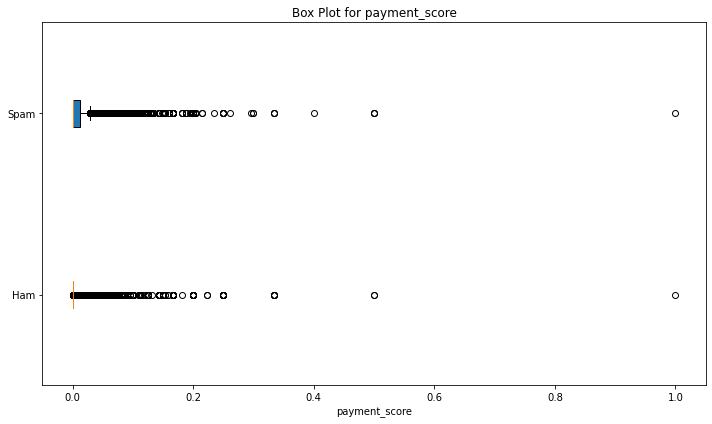

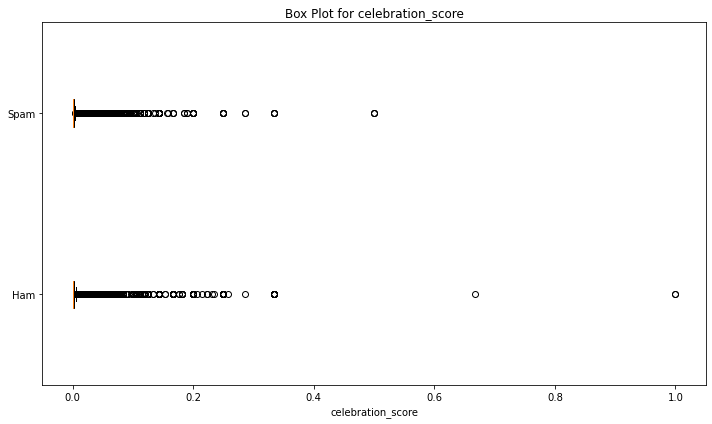

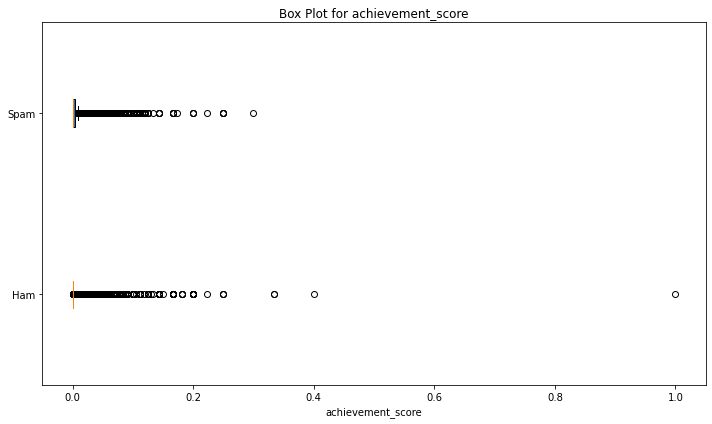

In [37]:
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    data = [grouped.get_group(label)[feature].values for label in grouped.groups]
    plt.boxplot(data, vert=False, patch_artist=True)
    
    # Set custom tick locations and labels
    ticks = [1, 2]  # Assuming only two categories (ham and spam)
    labels = ['Ham', 'Spam']
    plt.yticks(ticks, labels)
    
    plt.xlabel(feature)
    plt.title(f'Box Plot for {feature}')
    plt.tight_layout()
    plt.show()

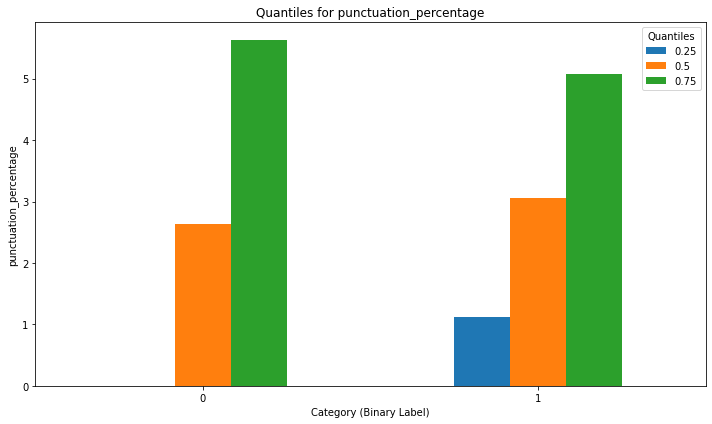

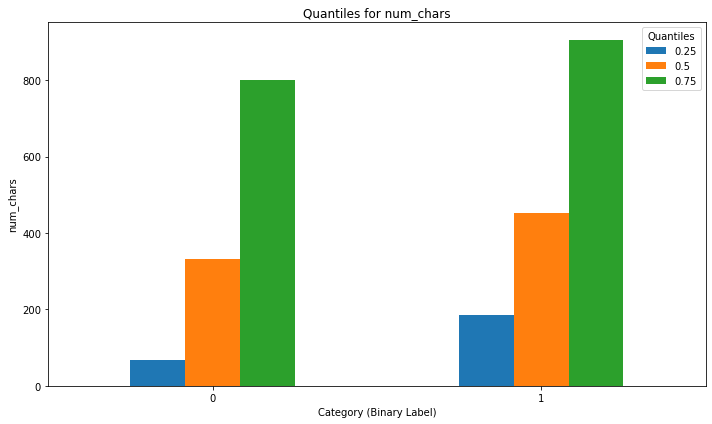

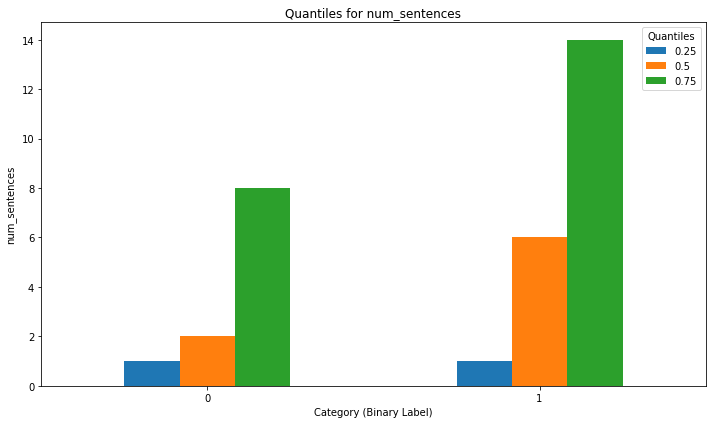

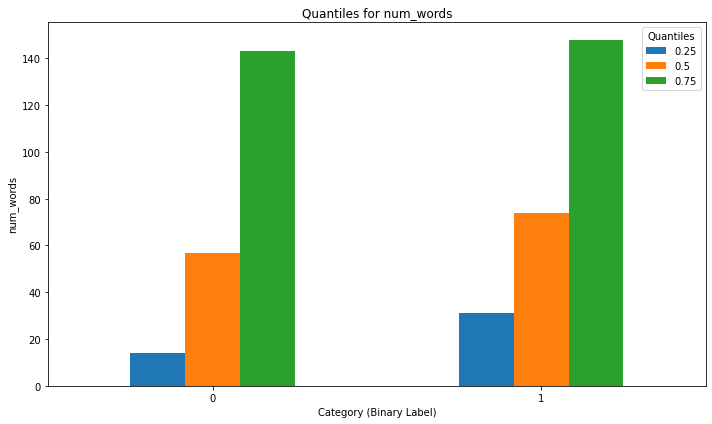

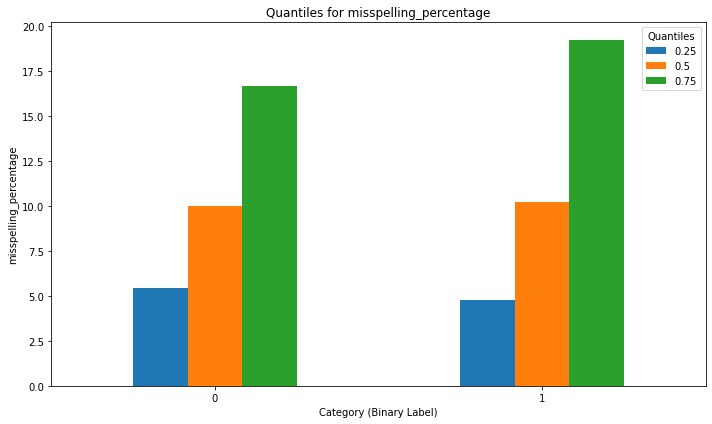

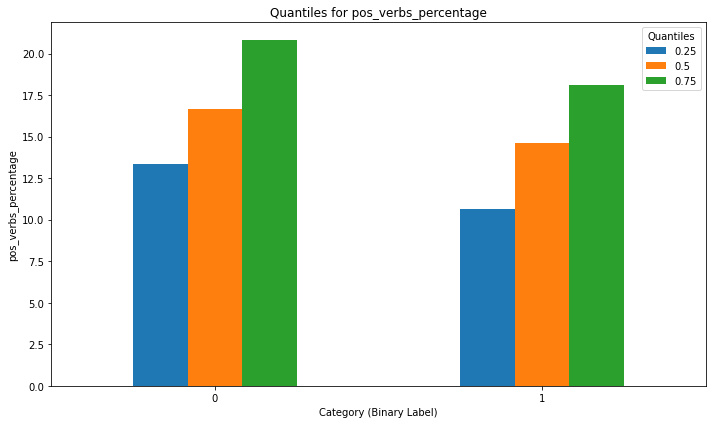

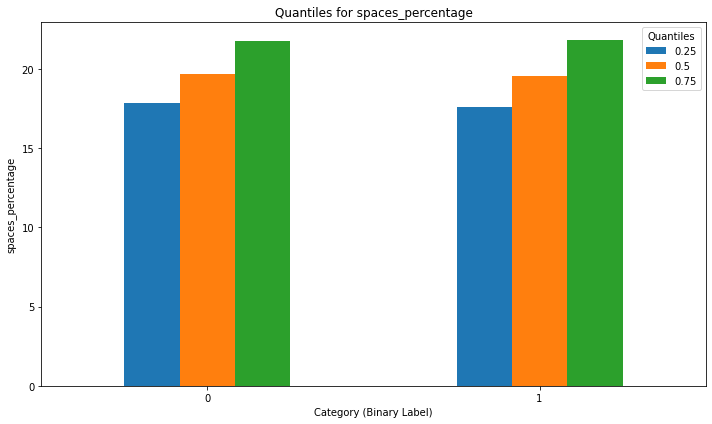

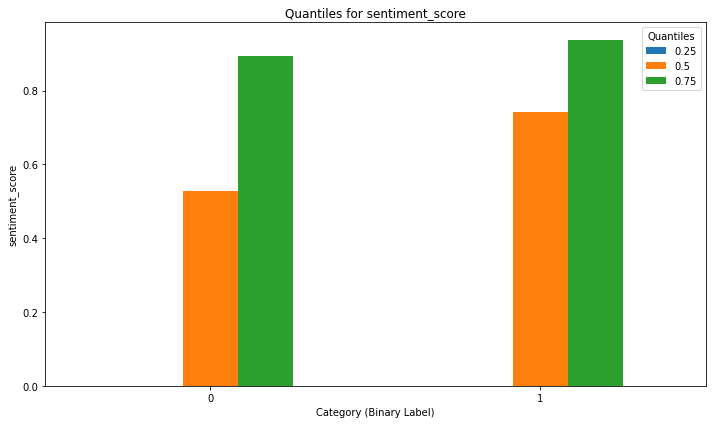

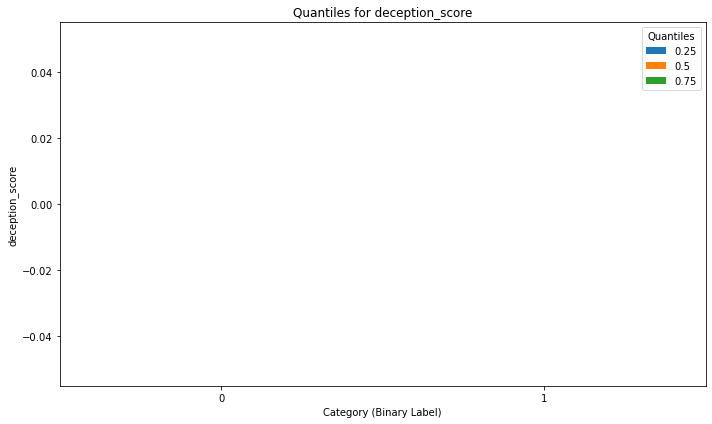

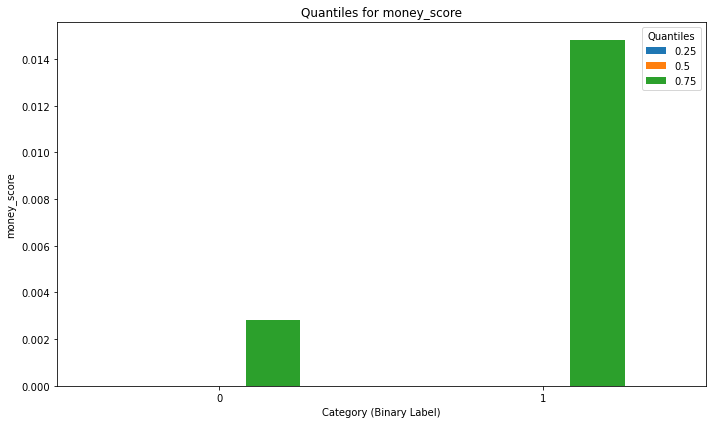

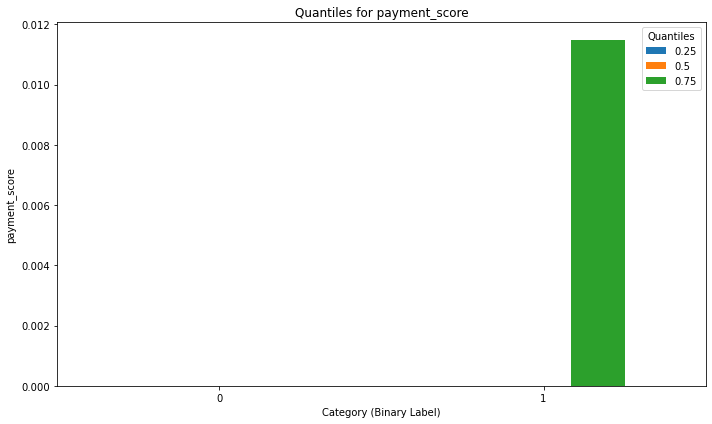

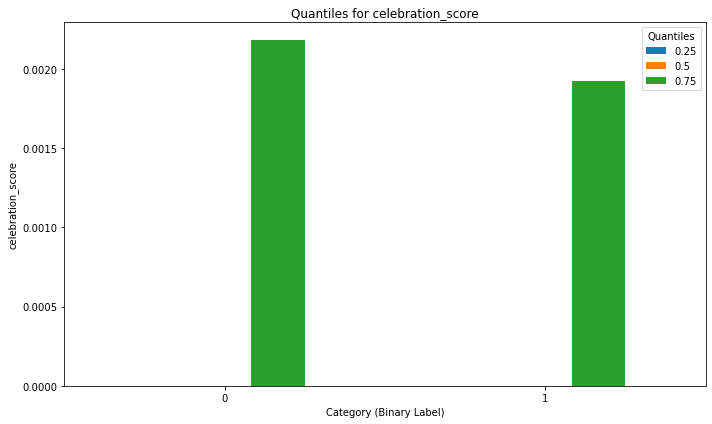

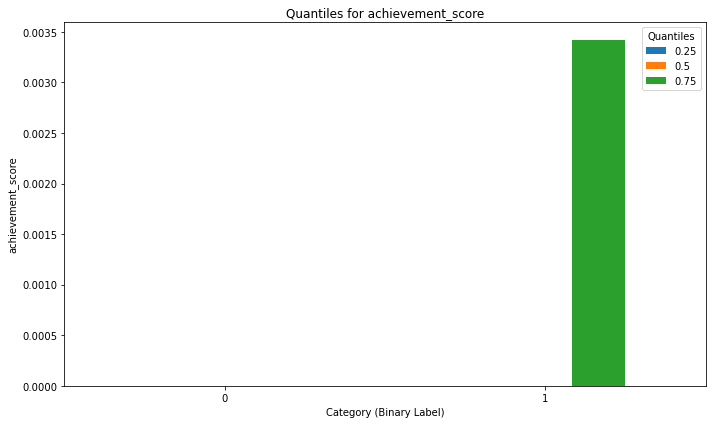

In [38]:
# Iterate over selected features
for feature in selected_features:
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Plot bar graph for the current feature
    quantiles[feature].unstack().plot(kind='bar', ax=plt.gca())
    
    # Set labels and title
    plt.xlabel('Category (Binary Label)')
    plt.ylabel(feature)
    plt.title(f'Quantiles for {feature}')
    plt.xticks(rotation=0)
    plt.legend(title='Quantiles')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

From the above plot, we observe that there are very few values for the following columns: ['deception_score', 'money_score', 'payment_score', 'celebration_score', 'achievement_score']. Hence we would like to check how many rows have value above 0 for these columns. 

In [39]:
columns = ['deception_score', 'money_score', 'payment_score', 'celebration_score', 'achievement_score']

percentage_greater_than_0 = grouped[columns].apply(lambda x: (x > 0).mean() * 100)

print("Percentage of values greater than 0 for each category:")
print(percentage_greater_than_0)

Percentage of values greater than 0 for each category:
              deception_score  money_score  payment_score  celebration_score  \
binary_label                                                                   
0                    4.689736    27.366619      24.214869          27.417137   
1                    8.363529    46.368080      42.243195          27.622820   

              achievement_score  
binary_label                     
0                     17.358480  
1                     29.788489  


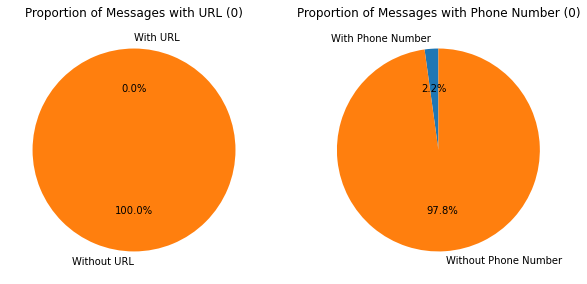

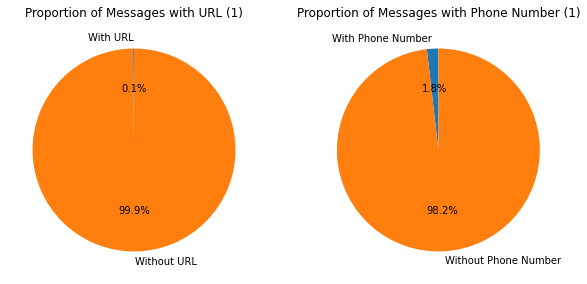

In [40]:
labels = ['With URL', 'Without URL', 'With Phone Number', 'Without Phone Number']

for label, group in grouped:
    total_messages = len(group)
    
    num_with_url = group['url_presence'].sum()
    num_without_url = total_messages - num_with_url
    
    num_with_phone = group['phone_number_presence'].sum()
    num_without_phone = total_messages - num_with_phone
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pie([num_with_url, num_without_url], labels=labels[:2], autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of Messages with URL ({label})')

    plt.subplot(1, 2, 2)
    plt.pie([num_with_phone, num_without_phone], labels=labels[2:], autopct='%1.1f%%', startangle=90)
    plt.title(f'Proportion of Messages with Phone Number ({label})')

    plt.show()

# 4) Feature Selection

## Normalisation


In [41]:
features = ['num_chars', 'num_sentences', 'num_words',
       'misspelling_percentage', 'pos_verbs_percentage',
       'spaces_percentage', 'sentiment_score',
       'deception_score', 'money_score', 'payment_score', 'celebration_score',
       'achievement_score', 'url_presence', 'phone_number_presence'] 

features_to_normalise = ['num_chars', 'num_sentences', 'num_words',
       'misspelling_percentage', 'pos_verbs_percentage',
       'spaces_percentage', 'sentiment_score',
       'deception_score', 'money_score', 'payment_score', 'celebration_score',
       'achievement_score'] 

df_norm = combined_df.copy()

In [42]:
scaler = MinMaxScaler()
for col in features_to_normalise:
    df_norm[col] = scaler.fit_transform(df_norm[[col]])
df_norm

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label,pos_verbs_percentage
0,ham,"Funny fact Nobody teaches volcanoes 2 erupt, t...","Funny fact Nobody teaches volcanoes 2 erupt, t...","['funni', 'fact', 'nobodi', 'teach', 'volcano'...",1.324503,0.000661,0.000330,0.000692,2,0.076923,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.038461...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,0.115385
1,ham,I sent my scores to sophas and i had to do sec...,I sent my scores to sophas and i had to do sec...,"['sent', 'score', 'sopha', 'secondari', 'appli...",1.809955,0.000968,0.000989,0.001145,2,0.046512,...,"{'help': 0.0, 'office': 0.023255813953488372, ...",0.0,0.046512,0.046512,0.000000,0.0,0,0,0,0.279070
2,spam,We know someone who you know that fancies you....,We know someone who you know that fancies you....,"['know', 'someon', 'know', 'fanci', 'call', 'f...",2.970297,0.000442,0.000989,0.000506,3,0.157895,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0.210526
3,ham,Only if you promise your getting out as SOON a...,Only if you promise your getting out as SOON a...,"['promis', 'get', 'soon', 'youll', 'text', 'mo...",2.419355,0.000543,0.000660,0.000772,2,0.068966,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,0,0.206897
4,spam,Congratulations ur awarded either �500 of CD g...,Congratulations ur awarded either 500 of CD gi...,"['congratul', 'ur', 'award', 'either', 'cd', '...",2.054795,0.000639,0.000330,0.000586,5,0.227273,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.043478,0.0,0,0,1,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59360,spam,Google oe\n\nGmail ~ 6 e a- d-\nImportant: You...,Google oe\n\nGmail ~ 6 e a- d-\nImportant: You...,"[oogl, oe, mail, e, mportant, assword, expir, ...",3.826531,0.001717,0.000660,0.001705,12,0.187500,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0.140625
59361,spam,FedEx.\n\nExpress\nParcel Tracking\n\nDear Cus...,FedEx.\n\nExpress\nParcel Tracking\n\nDear Cus...,"[edx, xpress, arcel, rack, ear, ustom, packag,...",1.000000,0.001314,0.000989,0.001305,3,0.061224,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0.163265
59362,spam,"HiAll,\n\nThis is to provide notice of our new...","HiAll,\n\nThis is to provide notice of our new...","[ill, provid, notic, new, compani, polici, reg...",2.736842,0.002080,0.001649,0.002104,4,0.050633,...,"{'help': 0.0375, 'office': 0.025, 'dance': 0.0...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0.113924
59363,spam,Don't trust an email\njust because it's\nfrom ...,Don't trust an email\njust because it's\nfrom ...,"[ont, trust, email, msvuca, rom, ent, riday, e...",3.860523,0.003516,0.002309,0.003489,12,0.091603,...,"{'help': 0.03076923076923077, 'office': 0.0076...",0.0,0.000000,0.000000,0.000000,0.0,0,0,1,0.213740


## Feature Ranking
We will only be taking the top 11 features, this is because the chi2 scores beyond that is too insignificant. 

In [43]:
X = df_norm[features] 
y = df_norm['binary_label']

selector = SelectKBest(score_func=chi2, k=14)
X_new = selector.fit_transform(X, y)

selected_feature_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_feature_indices]

print("Selected features:", selected_features)

Selected features: Index(['num_chars', 'num_sentences', 'num_words', 'misspelling_percentage',
       'pos_verbs_percentage', 'spaces_percentage', 'sentiment_score',
       'deception_score', 'money_score', 'payment_score', 'celebration_score',
       'achievement_score', 'url_presence', 'phone_number_presence'],
      dtype='object')


In [44]:
chi2_scores = selector.scores_
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': chi2_scores})
feature_scores_df = feature_scores_df.sort_values(by='Chi2 Score', ascending=False)

feature_scores_df.reset_index()[['Feature', 'Chi2 Score']] #higher chi2 score is better

,Feature,Chi2 Score
0,money_score,77.619538
1,pos_verbs_percentage,71.368185
2,payment_score,70.484944
3,url_presence,51.042976
4,sentiment_score,27.960439
5,achievement_score,18.787652
6,misspelling_percentage,9.862548
7,phone_number_presence,9.177269
8,spaces_percentage,6.884159
9,num_sentences,4.567206


# 5) Splitting data into train and test set

In [47]:
final_df = df_norm[['label', 'text', 'cleaned_text', 'preprocessed_tokens',
       'punctuation_percentage', 'num_sentences',
       'num_misspellings', 'misspelling_percentage', 'num_pos_verbs',
       'spaces_percentage', 'sentiment_score', 'money_score', 'payment_score', 
       'celebration_score', 'achievement_score', 'url_presence', 
       'phone_number_presence','binary_label', 'pos_verbs_percentage']]

train_df, test_df = train_test_split(df_norm, test_size=0.2, random_state=42)
train_df

,label,text,cleaned_text,preprocessed_tokens,punctuation_percentage,num_chars,num_sentences,num_words,num_misspellings,misspelling_percentage,...,emotions,deception_score,money_score,payment_score,celebration_score,achievement_score,url_presence,phone_number_presence,binary_label,pos_verbs_percentage
31763,spam,"calgary , alberta , jul 7 , 2005 ( ccnmatthews...","calgary , alberta , jul 7 , 2005 ( ccnmatthews...","['calgari', 'alberta', 'jul', 'ccnmatthew', 'v...",2.566049,0.028841,0.017150,0.026634,38,0.038000,...,"{'help': 0.004336513443191674, 'office': 0.011...",0.000867,0.015611,0.013010,0.001735,0.002602,0,0,1,0.152000
33386,ham,"louise , as of today there is $ 722 , 572 in s...","louise , as of today there is $ 722 , 572 in s...","['louis', 'today', 'schedul', 'c', 'tbg', 'set...",3.571429,0.002575,0.002309,0.002930,8,0.072727,...,"{'help': 0.0, 'office': 0.031007751937984496, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.190909
2732,ham,Lmao but its so fun...,Lmao but its so fun...,"['lmao', 'fun']",13.636364,0.000096,0.000330,0.000160,2,0.333333,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000
34944,ham,hi : here ' s the presentation . - - - - - ori...,hi : here ' s the presentation . - - - - - ori...,"['hi', 'present', 'origin', 'messag', 'kitchen...",8.040712,0.008605,0.004947,0.007484,84,0.298932,...,"{'help': 0.0, 'office': 0.011441647597254004, ...",0.000000,0.002288,0.000000,0.011442,0.000000,0,0,0,0.113879
19438,ham,fraud,fraud,['fraud'],0.000000,0.000022,0.000330,0.000027,0,0.000000,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",1.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,spam,splashmobile choose from 1000s of gr8 tones ea...,splashmobile choose from 1000s of gr8 tones ea...,"['splashmobil', 'choos', 'gr', 'tone', 'wk', '...",0.000000,0.000657,0.000330,0.000719,6,0.222222,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.000000,0.037037,0.037037,0.000000,0.000000,0,0,1,0.148148
38158,spam,= ? utf - 8 ? q ? incuring improved ? = = ? ut...,= ? utf - 8 ? q ? incuring improved ? = = ? ut...,"['utf', 'q', 'incur', 'improv', 'utf', 'q', 'p...",6.081081,0.001296,0.003628,0.001225,2,0.043478,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0.217391
860,spam,Hello from Orange. For 1 month's free access t...,Hello from Orange. For 1 month's free access t...,"['hello', 'orang', 'month', 'free', 'access', ...",7.051282,0.000683,0.000989,0.000719,2,0.074074,...,"{'help': 0.0, 'office': 0.0, 'dance': 0.0, 'mo...",0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0.074074
15795,ham,jcc that this email constitutes your groups vi...,jcc that this email constitutes your groups vi...,"['jcc', 'email', 'constitut', 'group', 'vinc',...",0.000000,0.002444,0.000330,0.002690,13,0.128713,...,"{'help': 0.009900990099009901, 'office': 0.0, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.188119


In [49]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [52]:
grouped_train = train_df.groupby('binary_label')
grouped_train.count()['label']/sum(grouped_train.count()['label'])

binary_label
0    0.599301
1    0.400699
Name: label, dtype: float64

In [53]:
grouped_test = test_df.groupby('binary_label')
grouped_test.count()['label']/sum(grouped_test.count()['label'])

binary_label
0    0.603807
1    0.396193
Name: label, dtype: float64